<a href="https://colab.research.google.com/github/adewong-dotcom/portfolio/blob/main/Copy_of_%5BMLOps%5D_Week_2_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### Problem

In the project this week, we will conduct detailed model evaluation, data quality testing and behavioral testing for the news classification model from the week 1 project.

1. We will look at evaluation metrics beyond overall accuracy and f1 score (per-class metrics, confusion matrix, per-class false positive and false negative errors)
2. We will implement bootstrap sampling to measure confidence intervals of model performance metrics
3. We will implement behavioral tests using a popular open source library called checklist
4. [advanced] Advanced data quality and behavioral tests

### Deliverables
1. Test set per-class accuracy, precision, recall and F-1 score
2. Test set confusion matrix, and per-class false positive, false negative errors 
3. 95% confidence intervals for test set metrics as estimated via bootstrap sampling
4. Behavioral tests for the trained news classification model, using checklist. 
5. [Optional] Advanced data quality and behavioral tests



## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [ ]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install gensim
!pip install sentence-transformers
!pip install matplotlib
!pip install great_expectations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 4.4 MB 13.1 MB/s 
     |████████████████████████████████| 1.2 MB 50.4 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |████████████████████████████████| 6.6 MB 65.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=a44a690a8996913935810cc3fa41db90589b3b25fef206c01fa7f9179acc3d7b
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61e

In [ ]:
# Package imports that will be needed for this project

import numpy as np
import json
from sentence_transformers import SentenceTransformer
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as sklearn_metrics

In [ ]:
# Global Constants

LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

EMBEDDING_MODEL = 'all-mpnet-base-v2'
DATA_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project2/agnews.zip'

## Step 2: Download and Load Dataset

[AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) is a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. The news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626). The dataset has the text description (summary) of the news article along with some metadata. **For this project, we will use a slightly modified (cleaned up) version of this dataset** 

Schema:
* Source - News publication source
* URL - URL of the news article
* Title - Title of the news article
* Description - Summary description of the news article
* Embedding - 768 dimensional embedding representation of the news article text (description) 
* Category (Label) - News category

Sample row in this dataset:
```
{
   'description': 'A capsule carrying solar material from the Genesis space probe has made a crash landing at a US Air Force training facility in the US state of Utah.',
   'id': 86273,
   'label': 'Entertainment',
   'source': 'Voice of America',
   'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
   'Embedding': [....],
   'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'
}
```

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"


def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json 
    """
    http_response = urlopen(DATA_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)


# Expensive operation so we should just do this once
download_dataset()


In [ ]:
Datasets = {}

for ds in ['train', 'test']:
    with open('data/{}.json'.format(ds), 'r') as f:
        Datasets[ds] = json.load(f)
    print("Loaded Dataset {0} with {1} rows".format(ds, len(Datasets[ds])))

print("\nExample dataset row:\n")
pprint(Datasets['train'][0])

Loaded Dataset train with 25000 rows
Loaded Dataset test with 50000 rows

Example dataset row:

{'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
 'embedding': [0.014944990165531635,
               -0.012602416798472404,
               0.022629551589488983,
               -0.004524254705756903,
               0.030837086960673332,
               -0.036378033459186554,
               -0.009855341166257858,
               0.03661152347922325,
               0.006519013550132513,
               0.01946776919066906,
               -0.04761530086398125,
               0.022138206288218498,
               0.032830338925123215,
               0.04278254881501198,
               0.02766306698322296,
               0.043008096516132355,
               0.0386490561068058,
               0.009227401576936245,
               -0.0084016676992177

## Step 3: Data Quality Tests

In Week 2 instruction, we learned about the importance of evaluating data quality across the ML lifecycle:
* When building your first ML model, you often have no data and have to invest in annotation resources to get labels
* Dataset labels can be noisy as they are collected from a variety of different sources.
* Real world evolves (drift) and so should the datasets you’re using to train models (to make sure they evolve along with it). 

[Great Expectations](https://docs.greatexpectations.io/docs/) is a popular Python library for validating data in Machine Learning pipelines. It contains several built-in Expectation types to configure tests, as well as integrations with common data structures used to store datasets (e.g. Pandas dataframes, CSV files, MySQL databases etc). We will be using this library to define and run some data quality tests for our dataset. The goal and scope of the exercise here is to get you acquainted with the library and practice of testing for data quality.

Useful references for this section:
1. Documentation: https://docs.greatexpectations.io/docs/
2. Using Great Expections in Jupyter: https://docs.greatexpectations.io/docs/guides/miscellaneous/how_to_quickly_explore_expectations_in_a_notebook 
3. List of predefined Expecations: https://greatexpectations.io/expectations/
4. Creating custom Expecations for Pandas dataframes: https://github.com/great-expectations/great_expectations/blob/develop/docs_rtd/guides/how_to_guides/creating_and_editing_expectations/how_to_create_custom_expectations_for_pandas.rst 

In [ ]:
import pandas as pd
import great_expectations as ge
from great_expectations.dataset import PandasDataset, MetaPandasDataset

class AGNewsPandasDataset(PandasDataset):

    _data_asset_type = "AGNewsPandasDataset"

    @MetaPandasDataset.column_map_expectation
    def expect_column_string_not_null_or_empty(self, column):
        """
        [TO BE IMPLEMENTED]
        
        Write a custom expectation that checks that the string column's value for each
        row is not NULL and not an empty string

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        #Code implemented
        return column.map(lambda x: x != None and x != "" and len(x) > 0)
        #return None

    @MetaPandasDataset.column_map_expectation
    def expect_column_embedding_dimensionality(self, column, dimension):
        """
        [TO BE IMPLEMENTED]
        
        Write a custom expectation that checks that the embedding column's value for each
        row is not NULL and dim(embedding) == dimension

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        #Code implemented
        #return column.map(lambda x: column.value != None and self.column['embedding'].shape == dimension)
        return column.map(lambda x: x != None and column.ndim == dimension)
        #Code given
        #return None
    
    @MetaPandasDataset.column_map_expectation
    def expect_column_in_range(self, column, range_min, range_max):
        """
        [TO BE IMPLEMENTED]
        
        Write a custom expectation that checks that the column's value for each
        row is in range [range_min, range_max]

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        #Code implemented
        numbers_in_column = column.map(lambda x: int(x))
        if range_min is not None and range_max is not None:
          return numbers_in_column.map(lambda x: range_min <= x <= range_max)
        elif range_min is not None and range_max is None:
          return numbers_in_column.map(lambda x: range_min <= x)
        elif range_min is None and range_max is not None:
          return numbers_in_column.map(lambda x: x <= range_max)
        else:
          return numbers_in_column.map(lambda x: True)
        #Code given
        #return None
    
    @MetaPandasDataset.column_map_expectation
    def expect_column_embedding_unit_norm(self, column):
        """
        [TO BE IMPLEMENTED]
        
        Write a custom expectation that checks that the embedding column's value for each
        row is not NULL and norm(embedding) == 1

        Your code should look something like this:
        column.map(lambda x: ...)
        """
        #Code implemented
        #initialize vector where column.ndim is the number of dimensions
        # np.linalg.norm(vec) computes the norm of vector then evaluates if it equals 1
        return column.map(lambda x: x != None and np.isclose(np.linalg.norm(x), 1))
        #Code given
        #return None


In [ ]:
Dataframes = {}

for ds in ['train', 'test']:
    Dataframes[ds] = ge.from_pandas(
        pd.DataFrame.from_records(Datasets[ds]), 
        dataset_class=AGNewsPandasDataset
    )

In [ ]:
for ds in ['train', 'test']:
    """
    [TO BE IMPLEMENTED]
        
    Expect columns in Dataframes[ds] to match the column set: 
    {'id', 'source', 'title', 'url', 'rank', 'description', 'embedding', 'label'}
    """
    #Code implemented to check column set
    Dataframes[ds].expect_table_columns_to_match_set([ "id", "source", "title", "url", "rank", "description", "embedding", "label"])
    """
    [TO BE IMPLEMENTED]
        
    Expect the "id" column in Dataframes[ds] to be unique
    """
    #Code implemented to check if values of "id" are unique
    Dataframes[ds].expect_column_values_to_be_unique("id")
    """
    [TO BE IMPLEMENTED]
        
    Expect the "description" column in Dataframes[ds] not not be null or empty
    """
    #Code to make sure "description" is not null or empty
    Dataframes[ds].expect_column_string_not_null_or_empty("description")
    """ 
    [TO BE IMPLEMENTED]

    Expect the "embedding" column in Dataframes[ds] should be non-NULL and dimensionality = 768
    (Run this after implementing `expect_column_embedding_dimensionality` above)
    """
    #Code to make sure it's not null and check dimensionality
    Dataframes[ds].expect_column_embedding_dimensionality("embedding", 768)
    """ 
    [TO BE IMPLEMENTED]

    Expect the "embedding" column in Dataframes[ds] should be unit norm vectors
    (Run this after implementing `expect_column_embedding_unit_norm` above)
    """
    #Code to make sure "embedding" has unit norm vectors
    Dataframes[ds].expect_column_embedding_unit_norm("embedding")

    """ 
    [TO BE IMPLEMENTED]

    Expect the "rank" column in Dataframes[ds] should be in range [1, 5]
    """
    #Code to check if "rank" column is in the range (1, 5) inclusive
    Dataframes[ds].expect_column_in_range("rank", range_min = 1, range_max = 5)


In [ ]:
validation_train = Dataframes["train"].validate()

pprint(validation_train)


{
  "meta": {
    "great_expectations_version": "0.15.15",
    "expectation_suite_name": "default",
    "run_id": {
      "run_time": "2022-07-24T02:24:25.604086+00:00",
      "run_name": null
    },
    "batch_kwargs": {
      "ge_batch_id": "b63282bc-0af7-11ed-bfba-0242ac1c0002"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20220724T022425.603979Z",
    "expectation_suite_meta": {
      "great_expectations_version": "0.15.15"
    }
  },
  "success": false,
  "statistics": {
    "evaluated_expectations": 6,
    "successful_expectations": 4,
    "unsuccessful_expectations": 2,
    "success_percent": 66.66666666666666
  },
  "evaluation_parameters": {},
  "results": [
    {
      "result": {
        "observed_value": [
          "id",
          "source",
          "title",
          "url",
          "rank",
          "description",
          "embedding",
          "label"
        ]
      },
      "meta": {},
      "success": true,
      "expectation

In [ ]:
validation_test = Dataframes["train"].validate()

pprint(validation_test)


{
  "meta": {
    "great_expectations_version": "0.15.15",
    "expectation_suite_name": "default",
    "run_id": {
      "run_time": "2022-07-24T02:24:28.784393+00:00",
      "run_name": null
    },
    "batch_kwargs": {
      "ge_batch_id": "b63282bc-0af7-11ed-bfba-0242ac1c0002"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20220724T022428.784324Z",
    "expectation_suite_meta": {
      "great_expectations_version": "0.15.15"
    }
  },
  "success": false,
  "statistics": {
    "evaluated_expectations": 6,
    "successful_expectations": 4,
    "unsuccessful_expectations": 2,
    "success_percent": 66.66666666666666
  },
  "evaluation_parameters": {},
  "results": [
    {
      "result": {
        "observed_value": [
          "id",
          "source",
          "title",
          "url",
          "rank",
          "description",
          "embedding",
          "label"
        ]
      },
      "meta": {},
      "success": true,
      "expectation

In [ ]:
""" 
[TO BE IMPLEMENTED]

Take a look at the results from the data validation tests. You will observe that some rows in the 
training and test sets have failed the validation for the following test:

Expect the "description" column in Dataframes[ds] not not be null or empty

This is a good catch! We know that these rows in training or test set likely just add noise to the model
since it is not very relevant to ask the model to predict the category of a news article with no text.

In this step, you will filter out the rows from Datasets['train'] and Datasets['test']
and create a new Datasets_filtered object with the filtered datasets
"""

Datasets_filtered = {}

train_df = Dataframes["train"]
test_df = Dataframes["test"]

Datasets_filtered['train'] = train_df[train_df['description'] != ""]
Datasets_filtered['test'] = test_df[test_df['description'] != ""]

'''for ds in Dataframes['train']:
  if(Dataframes[ds].expect_column_string_not_null_or_empty("description")):
    Datasets_filtered['train'][ds].append(Dataframes[ds])
for ds in Dataframes['test']:
  if(Dataframes[ds].expect_column_string_not_null_or_empty("description")):
    Datasets_filtered['test'][ds].append(Dataframes[ds])'''




'for ds in Dataframes[\'train\']:\n  if(Dataframes[ds].expect_column_string_not_null_or_empty("description")):\n    Datasets_filtered[\'train\'][ds].append(Dataframes[ds])\nfor ds in Dataframes[\'test\']:\n  if(Dataframes[ds].expect_column_string_not_null_or_empty("description")):\n    Datasets_filtered[\'test\'][ds].append(Dataframes[ds])'

## Step 4: Fine-grained Model Evaluation

Model performance evaluation for real-world ML applications can often be complex since different stakeholders (ML engineers, product managers, sales teams) care about the impact on different dimensions. In this exercise, we will evaluate the News category classification from Week 1 in the following ways:


* **Aggregate performance metrics**: Using standard metrics to evaluate ML model performance such as accuracy, mean squared error, BLEU scores etc (depending on the ML task) is a necessary first step, but far from sufficient. It serves to filter out models that are clearly suboptimal and reduces risk of launching bad models

* **Slice-level performance metrics**: It is important to track model performance not just in aggregate but for important cohorts/slices of your traffic. For example, it is important to track the performance of your hate speech detection model not just in aggregate but for traffic from each country, language etc to understand the gaps in performance.
  
* **Qualitative evaluations**: Behavioral tests can be helpful to root-cause individual instances of model failures and yield helpful insights to improve models

In [ ]:
# In order to minimize variations from different model architectures & training procedures, 
# we will keep the model architecture and feature sets uniform

X_train, Y_train = [], []
X_test, Y_true = [], []

for row in Datasets_filtered['train'].iterrows():
    X_train.append(row[1]['embedding'])
    Y_train.append(row[1]['label'])

for row in Datasets_filtered['test'].iterrows():
    X_test.append(row[1]['embedding'])
    Y_true.append(row[1]['label'])

model = LogisticRegression(
    multi_class='multinomial',
    tol=0.001,
    solver='saga',
)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [ ]:
## This should be roughly in the same range as the results you got in Week 1

print("Accuracy on test set: {}".format(sklearn_metrics.accuracy_score(Y_true, Y_pred)))


Accuracy on test set: 0.7894556036050601


## Step 4 (Part 1): Confusion Matrix and Slice-based evaluation

As we saw with issues discussed around rare classes and model bias, evaluating the performance metrics at the overall dataset level is often not enough to deploy in production. Here are some commonly used axes along which ML teams commonly slice their datasets:

1. Labels (i.e. per-class performance)
2. Key categorical features or buckets of continuous features. E.g. a recommender system’s performance for each gender, age group.
3. Key traffic cohorts as defined by business value/regulatory requirements. E.g. a recommender system’s performance for newly registered users (it is important they have a good product experience else they will stop using the product)

In this exercise, we will dig into per-class performance

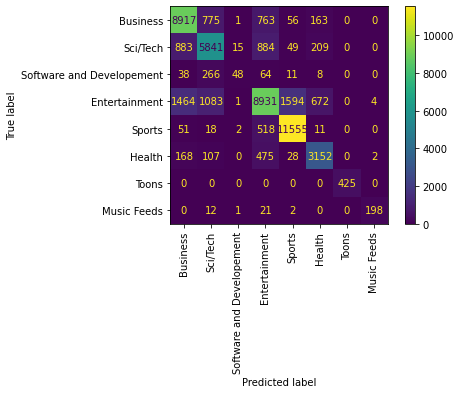

In [ ]:
""" 
[TO BE IMPLEMENTED]

Plot a confusion matrix for the news category classification model trained above. 
You should have a NxN matrix M, where 
N = len(LABEL_SET)
M(i, j) = number of instances in the test set where true_label = LABEL_SET[i] and pred_label = LABEL_SET[j]

Hint: check out sklearn.metrics 

"""
import matplotlib.pyplot as plt

cm = sklearn_metrics.confusion_matrix(Y_true, Y_pred, labels=LABEL_SET)
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_SET)
disp.plot(xticks_rotation = 'vertical')
plt.show()

In [ ]:
""" 
[TO BE IMPLEMENTED]

Compute the precision, recall and F1 score per-class for the test set

Hint: check out sklearn.metrics 
"""
print(sklearn_metrics.classification_report(Y_true, Y_pred, labels=LABEL_SET))


                           precision    recall  f1-score   support

                 Business       0.77      0.84      0.80     10675
                 Sci/Tech       0.72      0.74      0.73      7881
Software and Developement       0.71      0.11      0.19       435
            Entertainment       0.77      0.65      0.70     13749
                   Sports       0.87      0.95      0.91     12155
                   Health       0.75      0.80      0.77      3932
                    Toons       1.00      1.00      1.00       425
              Music Feeds       0.97      0.85      0.90       234

                 accuracy                           0.79     49486
                macro avg       0.82      0.74      0.75     49486
             weighted avg       0.79      0.79      0.78     49486



In [ ]:
import random 

def confusion_matrix_errors(X, Y, preds, true_label, pred_label, num_errors=100):
    """ 
    [TO BE IMPLEMENTED]

    Write a function `confusion_matrix_errors` that accepts the following inputs:
    1. The test dataset
    2. True and predicted labels for each row in the dataset
    3. A pair of labels (T, P)

    And returns the `num_errors` no. of errors from the test dataset where true_label = T and pred_label = P
    """
    errors = []
    for idx, (yt, yhat) in enumerate(zip(Y, preds)):
      if yt == true_label and yhat == pred_label:
        errors.append(X[idx])
    return random.sample(errors, num_errors)


""" 
[TO BE IMPLEMENTED]
Use the function implemented above to get some insights about the kind of examples that the model
is confused about for a given pair of classes
Some pairs to try out: ('Entertainment', 'Sports'), ('Health', 'Sports'), ('Business', 'Sci/Tech')
"""
for e in confusion_matrix_errors(Datasets['test'], Y_true, Y_pred, 'Entertainment', 'Sports'):
    print(e['description'])

Mark L. Attanasio is 46 years old. He was born in the Bronx, NY, lives in Los Angeles and made a fortune in investment banking. And he is about to buy a baseball team.
Google Inc. released free software yesterday that lets people simultaneously search the Web and their personal computers for information, a move analysts described as a potential blow to rivals Microsoft Corp.
Reuters - Mobile media company Zingy on\Monday said it signed deals to deliver voice recordings by\Grammy-nominated rapper Kanye West and songs from the late R B\singer Aaliyah to mobile phone users.
While on the moon, John Young drove a motorized rover 16 miles and spent three nights on the lunar surface. He is the only person to go into space as part of the Gemini, Apollo and shuttle programs and was
ISRAELI forces have mounted a new incursion into the south of the Gaza Strip, a military spokeswoman said. She said the Israeli forces went into the Rafah refugee camp, near the border with Egypt, to look
PENSACOLA, 

## Step 4 (Part 2): Estimating confidence intervals with Bootstrap sampling

When computing model performance metrics, the margin of error can vary a lot depending on the size of the test dataset. We are trying to estimate the model’s performance on any unseen data by empirically computing the model performance on the held-out test set, and trying to quantify the confidence intervals in this estimation: If we were to measure the model’s performance on another independently collected test dataset from the same underlying distribution, our model’s performance on this dataset is unlikely to be the same, but how different might they plausibly be? 

In this exercise, we will implement Bootstrap sampling to estimate the 95% confidence interval for 
overall accuracy and F1-score of the model:

1. Generate N ‘bootstrap sample’ datasets, each the same size as the original test set. Each bootstrap sample dataset is obtained by sampling instances uniformly at random from the original test set (with replacement).
2. On each of the bootstrap sample datasets, calculate the accuracy metric.
3. From Step (2), you will end up with N different accuracy values. Sort them.
4. The 95% confidence interval is given by the 2.5th to the 97.5th percentile among the N sorted accuracy values.


In [ ]:
def bootstrap_accuracy_distribution(Y_true, Y_pred, N = 1000):
    """ 
    [TO BE IMPLEMENTED]
    
    Implement this function that takes two lists: Y_true, Y_pred
    and the number of bootstrap trials (N). 
    
    It should return a list (ret) of length = N, where ret[i] = accuracy metric from i-th bootstrap sampling run
    """
    #bootstrap_vals = [0]*N
    bootstrap = np.random.randint(len(Y_pred), size=(N, len(Y_pred)))
    bs_vals = np.empty(N)
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)
    for i in range(N):
      y_pred_i = Y_pred[bootstrap[i]]
      y_true_i = Y_true[bootstrap[i]]
      bs_vals[i] = sklearn_metrics.accuracy_score(y_true_i, y_pred_i)

    return bs_vals



95 percent confidence interval: [0.7858990421533363, 0.7929515418502202]


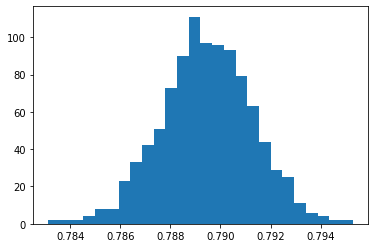

In [ ]:
import matplotlib.pyplot as plt
NUM_BOOTSTRAP = 1000

bs_vals = bootstrap_accuracy_distribution(Y_true, Y_pred, NUM_BOOTSTRAP)
bs_vals = sorted(bs_vals)

print("95 percent confidence interval: [{0}, {1}]".format(
    bs_vals[25],    # 2.5th percentile
    bs_vals[975]    # 97.5th percentile
))

_ = plt.hist(bs_vals, bins='auto')
plt.show()

## Step 4 (Part 3): Minimum Functionality behavioral Tests

Unit tests and integration tests play an important role in testing software for bugs, inefficiencies and potential vulnerabilities. Can we employ a similar approach to testing ML models? This exercise introduces the concept of “behavioral testing”  for machine learning models. 

Minimum Functionality Tests are a class of behavioral tests, and equivalents of “unit tests in software engineering” - a collection of simple examples (and labels) to check a behavior. A recommended practice is to write minimum functionality tests for highly visible/high cost potential failure modes, and for failure modes that you uncover during error analysis to guard against such failures in the future. 

For this exercise, we will use a popular open source library called [Checklist](https://github.com/marcotcr/checklist) to configure and run behavioral tests for our model. The goal and scope of the exercise here is to get you acquainted with the library and practice of testing for minimum functionality. 

Useful references:
1. Getting started with Checklist: https://github.com/marcotcr/checklist
2. Creating & Running tests with Checklist: https://github.com/marcotcr/checklist/blob/9baab717e44e216697f7ef0730ee269db9ef7d5b/notebooks/tutorials/3.%20Test%20types,%20expectation%20functions,%20running%20tests.ipynb 

In [ ]:
!pip install checklist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached checklist-0.0.11.tar.gz (12.1 MB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached patternfork_nosql-3.6.tar.gz (22.3 MB)
  Using cached iso-639-0.4.5.tar.gz (167 kB)
     |████████████████████████████████| 81 kB 5.0 MB/s 
     |████████████████████████████████| 5.6 MB 43.8 MB/s 
     |████████████████████████████████| 5.6 MB 57.8 MB/s 
     |████████████████████████████████| 348 kB 60.6 MB/s 
     |████████████████████████████████| 104 kB 47.4 MB/s 
  Created wheel for checklist: filename=checklist-0.0.11-py3-none-any.whl size=12165635 sha256=1cebffeec9e0113bb69c5d05cc45fe01df169a3b54530db06b1def7d976cb26a
  Stored in directory: /root/.cache/pip/wheels/6a/8a/07/6446879be434879c27671c83443727d74cecf6b630c8a24d03
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=169061 sha256=88044499f5a364b91205ae8f67e0852a0dd3e8eb93a132e5b85f01

In [ ]:
import nltk
nltk.download('omw-1.4')
import checklist
from checklist.editor import Editor
from checklist.test_types import MFT
from checklist.pred_wrapper import PredictorWrapper

# Run some warmup code to get you familiar with templates in checlist
editor = Editor()
ret = editor.template('{first_name} is {a:profession} from {country}.',
                      profession=['lawyer', 'doctor', 'accountant'])
np.random.choice(ret.data, 3)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


array(['Kelly is an accountant from Saint Kitts and Nevis.',
       'Don is a lawyer from Angola.', 'Hugh is a doctor from Nigeria.'],
      dtype='<U67')

In [ ]:
""" 
[TO BE IMPLEMENTED]

Part 1: Data Generation for behavioral tests

1. News Source variation:
{source}: Astronomers expect the Perseid meteor shower to be one of the best versions of the shooting star events in several years
source = ['New York Times', 'Reuters', 'AP', 'Wall Street Journal', 'Quanta', 'BBC', 'BBC UK', 'Yahoo News']
label = "Sci/Tech"

2. Company Name variation:
{company} revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
company = ['McDonalds', 'Starbucks', 'Chipotle', 'Krispy Creme', 'Unknown Company']
label = "Sci/Tech"

3. Company Name variation: // same as test 2
{company} revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
company = ['McDonalds', 'Starbucks', 'Chipotle', 'Krispy Creme', 'Unknown Company']
label = "Sci/Tech"

4. 
{disease} will come under the {mask} during the charity gala event being held on Monday at 7pm
disease = ['Breast cancer', 'Heart disease', 'Diabetes']
"""

editor = Editor()
# [TO BE IMPLEMENTED]
ret = editor.template('{source}: Astronomers expect the Perseid meteor shower to be one of the best versions of the shooting star events in several years',
source = ['New York Times', 'Reuters', 'AP', 'Wall Street Journal', 'Quanta', 'BBC', 'BBC UK', 'Yahoo News'],
labels = "Sci/Tech")
ret += editor.template('{company} revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.',
company = ['McDonalds', 'Starbucks', 'Chipotle', 'Krispy Creme', 'Unknown Company'],
labels = "Sci/Tech")
ret += editor.template('{disease} will come under the {mask} during the charity gala event being held on Monday at 7pm',
disease = ['Breast cancer', 'Heart disease', 'Diabetes'], labels = "Health")




In [ ]:
""" 
Part 2: Test Configuration
"""
#Lines 627 to 664 of code were very helpful ( https://github.com/marcotcr/checklist/blob/master/checklist/editor.py)
test = MFT(ret.data, labels=ret.labels, name='AG News MFT tests', capability=None, description='Very simple articles')

In [ ]:
""" 
Part 3: Test Run & Results summary
"""

def encode_and_predict(inputs):
    encoder = SentenceTransformer(
        'sentence-transformers/{model}'.format(model=EMBEDDING_MODEL)
    )
    encodings = [encoder.encode(x, normalize_embeddings=True) for x in inputs]
    return model.predict(encodings)

# wrapped_pp returns a tuple with (predictions, softmax confidences)
wrapped_pp = PredictorWrapper.wrap_predict(encode_and_predict)
test.run(wrapped_pp, overwrite=True)
test.summary()

Predicting 313 examples


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Test cases:      313
Fails (rate):    11 (3.5%)

Example fails:
Business Starbucks revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----
Entertainment Breast cancer will come under the stage during the charity gala event being held on Monday at 7pm
----
Business Krispy Creme revealed Thursday that its old recipe of adding stores is longer is a source of new profits for the company.
----


## Step 5: [Optional] Advanced data quality and behavioral tests

In the previous steps, you have familiarized yourself with libraries for writing data quality tests (great expectations) and behavioral tests (checkist). Take it out for a spin! A few possible extensions you can try:

1. **Model invariance behavioral tests** -- in step 4, we wrote some minimum functionality tests. Can you design some useful invariance behavioral tests? 

2. **Embedding drift based data quality checks across Training/Test datasets** -- in step 3, we wrote some data quality tests. If we wanted to check for drift in embedding space between training and test data, how might we construct a data quality test for this? Hint: The distribution of euclidean distance between pairs of embeddings within the training, and between the training and test dataset should be “almost the same”

